# Feature Engineering & Feature Selection

## Homework #4 by Glaktionova Natalia

APS Failure and Operational Data for Scania Trucks

**Опробованные методы**

- Удаление пустых значений 
- Замена пустых значений модой
- Удаление скоррелированных значений
- Отбор признаков с помощью регуляризации
- Удаление выбросов

Лучший результат получился после работы с пустыми значениями и при удалении выбросов, выходящих за пределы стандартного отклонения, на всем датасете


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [2]:
import warnings
warnings.filterwarnings("ignore")

Считываем и просматриваем данные

In [3]:
df_train = pd.read_csv('data/to_uci/aps_failure_training_set.csv', skiprows=20)
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 39.4+ MB


Посмотрим на целевую переменную

In [5]:
df_train['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

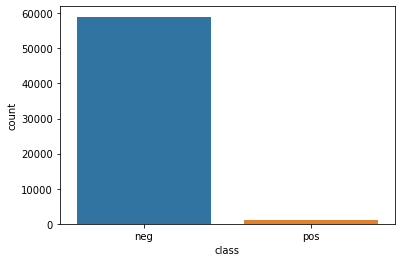

In [6]:
sns.countplot(df_train['class'],label="Count");

В описании датасета указано, что пустые значения заменены на **na**

In [7]:
prct_missing = (df_train.isin(['na']).sum() / df_train.shape[0] * 100).round(2)
print("\nFeatures with NaNs: {}/{}".format(len(prct_missing[prct_missing>0]), len(prct_missing)))


Features with NaNs: 169/171


Заменяем на NAN

In [8]:
df_train = df_train.applymap(lambda x: np.nan if x=='na' else x)

Полностью заполненных строк очень мало, просто удалить пустые мы не можем

In [9]:
df_train.dropna().shape[0]

591

Попробуем рассмотреть признаки с точки зрения типа object и уникальности 

In [10]:
nuniq = df_train.nunique()

168 признаков имеют свыше 20 уникальных значений 

In [11]:
nuniq.sort_values(ascending=True)

cd_000        1
class         2
ch_000        2
as_000       21
ef_000       28
          ...  
bv_000    49346
cq_000    49347
bu_000    49349
bb_000    49392
bx_000    52848
Length: 171, dtype: int64

У признака cd_000 всего одно уникальное значение. Этот столбец нам не поможет, можем удалить

In [12]:
df_train.cd_000.value_counts()

1209600    59324
Name: cd_000, dtype: int64

In [13]:
df_train.drop(columns=['cd_000'], inplace=True)

Т.к. уникальных значений почти всех признаков слишком много, приведем все признаки кроме целевого к типу float

In [14]:
df_train_num = df_train.iloc[:,1:].astype('float64')

In [15]:
df_train_num = pd.concat([df_train['class'], df_train_num], axis=1)

Перекодируем целевую переменную

In [16]:
labelencoder = LabelEncoder()
df_train_num['class'] = labelencoder.fit_transform(df_train_num['class'])

In [17]:
df_train_num.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


### Пустые значения

Посмотрим еще раз на признаки с пустыми значениями. В 8 признаках количество пропущенных значений свыше 60%. Их удалим, в оставшихся заменим пустые значения на моду

In [18]:
col_na = (df_train_num.isna().sum() / df_train_num.shape[0] * 100).round(2).sort_values(ascending=False)
col_na[col_na>60]

br_000    82.11
bq_000    81.20
bp_000    79.57
ab_000    77.22
bo_000    77.22
cr_000    77.22
bn_000    73.35
bm_000    65.92
dtype: float64

In [19]:
df_train_num.drop(columns=col_na[col_na>60].index, inplace=True)

In [20]:
def fill_NA(data, strategy='mean', NA_cols=[]):
    data_copy = data.copy(deep=True)
    for c in NA_cols:
        if data_copy[c].isnull().sum()>0:
            if strategy=='mean':
                data_copy[c] = data_copy[c].fillna(data[c].mean())
            elif strategy=='median':
                data_copy[c] = data_copy[c].fillna(data[c].median())
            elif strategy=='mode':
                data_copy[c] = data_copy[c].fillna(data[c].mode()[0])
    return data_copy

In [21]:
df_num_fillna = fill_NA(df_train_num, strategy='mode', NA_cols=df_train_num.columns[1:])

In [22]:
df_num_fillna.head(5)

,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698.0,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040.0,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874.0,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


### Baseline

In [23]:
def data_split_train_test(data, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['class'], axis=1),
    data['class'],
    test_size=test_size,
    stratify=data['class'],
    random_state=0)

    print("Train_shape:", X_train.shape, "Test shape:", X_test.shape)
    
    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = data_split_train_test(df_num_fillna)

Train_shape: (29419, 161) Test shape: (18000, 161)


In [25]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    return X_train_scaled, X_test_scaled

In [26]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

In [27]:
model_LogR = LogisticRegression(solver="liblinear")
model_LogR.fit(X_train_scaled, y_train)
pred = model_LogR.predict(X_test_scaled)

In [28]:
def quality_report(prediction, actual, verbose=True):
    report_str = "Accuracy: \t {:.3f}\n" +\
                 "Precision: \t {:.3f}\n" +\
                 "Recall: \t {:.3f}\n" +\
                 "f1_score: \t {:.3f}\n" +\
                 "ROC-AUC: \t {:.3f}"
    
    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual)
    recall = recall_score(prediction, actual)
    f1 = f1_score(prediction, actual)
    rocauc = roc_auc_score(prediction, actual)
    
    return [acc, precision, recall, f1, rocauc]

In [29]:
def assess_data(data, df_quality, exp_name, verbose=False):
    X_train, X_test, y_train, y_test = data_split_train_test(data)
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

    model_LogR = LogisticRegression(solver="liblinear")
    model_LogR.fit(X_train_scaled, y_train)
    pred = model_LogR.predict(X_test_scaled)

    quality_list = quality_report(pred, y_test.values, verbose=verbose)
    
    df_quality.loc[exp_name, :] = quality_list
    
    return df_quality.round(3)

In [30]:
quality_list_baseline = quality_report(pred, y_test)

In [31]:
df_quality = pd.DataFrame(
    [quality_list_baseline],
    columns=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
    index=["baseline"]
)
df_quality.round(3)

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.994,0.65,0.315,0.424,0.657


### Корреляция

Много значений мы заполнили сами, но попробуем проверить корреляцию признаков

In [32]:
Corr = df_num_fillna.corr()

Рассмотрим все признаки с корреляцией 0,85 и выше

In [33]:
corr_stack = (Corr.where(np.triu(np.ones(Corr.shape), k = 1)
                        .astype(np.bool))
                        .stack()
                        .sort_values(ascending=False))

In [34]:
corr_stack[abs(corr_stack) > 0.85]

bv_000  cq_000    1.000000
bu_000  cq_000    1.000000
        bv_000    1.000000
cf_000  co_000    1.000000
ad_000  cf_000    1.000000
                    ...   
by_000  ee_003    0.852448
ba_001  ba_004    0.851932
ba_002  by_000    0.851419
ag_006  ba_000    0.851190
ba_000  cs_005    0.850081
Length: 215, dtype: float64

In [35]:
selected_columns = corr_stack[abs(corr_stack) > 0.85].index.tolist()
selected_columns = np.unique(np.asarray(selected_columns).ravel())
selected_columns

array(['aa_000', 'ad_000', 'ag_002', 'ag_003', 'ag_004', 'ag_005',
       'ag_006', 'ag_007', 'ah_000', 'al_000', 'am_0', 'an_000', 'ao_000',
       'ap_000', 'aq_000', 'ay_002', 'ay_003', 'az_005', 'ba_000',
       'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006',
       'bb_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bt_000',
       'bu_000', 'bv_000', 'bx_000', 'by_000', 'cc_000', 'cf_000',
       'ci_000', 'cn_001', 'cn_002', 'cn_003', 'cn_004', 'cn_005',
       'co_000', 'cq_000', 'cs_002', 'cs_003', 'cs_005', 'cv_000',
       'dc_000', 'dl_000', 'dm_000', 'dn_000', 'do_000', 'dp_000',
       'ds_000', 'dt_000', 'ec_00', 'ed_000', 'ee_000', 'ee_001',
       'ee_002', 'ee_003', 'ee_004'], dtype='<U6')

Убираем столбцы с сильной корреляцией

In [36]:
df_num_fillna_wocorr = df_num_fillna.drop(columns=selected_columns)

In [37]:
df_quality = assess_data(df_num_fillna_wocorr, df_quality, 
                         exp_name="without_corr")

df_quality

Train_shape: (29419, 97) Test shape: (18000, 97)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.994,0.65,0.315,0.424,0.657
without_corr,0.994,0.55,0.273,0.365,0.636


Мы ухудшили baseline, этот способ не подходит

### Регуляризация

Попробуем отобрать признаки с помощью регуляризации

In [38]:
def get_reg_coefs(X_train, y_train, feature_columns, penalty="l1"):
    possible_Cs = np.arange(0.001,0.1,0.001)
    coefs_values = []

    for c in possible_Cs:
        model_LogR = LogisticRegression(C=c, penalty=penalty, solver="liblinear")
        model_LogR.fit(X_train_scaled, y_train)
        coefs_values.append(model_LogR.coef_[0])
    
    return pd.DataFrame(coefs_values, columns=feature_columns).sort_index(ascending=False).reset_index(drop=True)

In [39]:
#coefs_df_l2 = get_reg_coefs(X_train_scaled, y_train, X_train.columns, penalty="l2")
coefs_df_l1 = get_reg_coefs(X_train_scaled, y_train, X_train.columns, penalty="l1")

In [40]:
def get_important_features(coefs_df_l1, n_feats_limit):
    n_imp_feats = (coefs_df_l1!=0).sum(axis=1)
    index_imp_feats = n_imp_feats[n_imp_feats<=n_feats_limit].index[0]
    row_coef = coefs_df_l1.loc[index_imp_feats, :]
    return row_coef[row_coef!=0].index.tolist()

Найдем 10 и 20 самых важных признаков

In [41]:
reg_important_10_features = get_important_features(coefs_df_l1, n_feats_limit=10)
reg_important_20_features = get_important_features(coefs_df_l1, n_feats_limit=20)

reg_important_10_features, reg_important_20_features

(['aa_000',
  'ag_003',
  'ay_008',
  'bj_000',
  'bu_000',
  'bv_000',
  'ci_000',
  'cq_000'],
 ['aa_000',
  'ag_002',
  'am_0',
  'aq_000',
  'ay_000',
  'ay_003',
  'ay_005',
  'ay_008',
  'bs_000',
  'ci_000',
  'cj_000',
  'ck_000',
  'cn_001',
  'df_000',
  'di_000',
  'do_000',
  'dt_000',
  'ee_005',
  'ee_007',
  'ee_008'])

In [42]:
df_quality = assess_data(df_num_fillna[["class"]+reg_important_10_features], df_quality, 
                         exp_name="reg_important_10_features")

df_quality

Train_shape: (29419, 8) Test shape: (18000, 8)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.994,0.650,0.315,0.424,0.657
without_corr,0.994,0.550,0.273,0.365,0.636
reg_important_10_features,0.992,0.533,0.219,0.311,0.609


In [43]:
df_quality = assess_data(df_num_fillna[["class"]+reg_important_20_features], df_quality, 
                         exp_name="reg_important_20_features")

df_quality

Train_shape: (29419, 20) Test shape: (18000, 20)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.994,0.650,0.315,0.424,0.657
without_corr,0.994,0.550,0.273,0.365,0.636
reg_important_10_features,0.992,0.533,0.219,0.311,0.609
reg_important_20_features,0.995,0.617,0.330,0.430,0.665


На 10 признаков метрики ухудшились, а на 20 немного улучшились

### Выбросы

In [44]:
df_reg_20 = df_num_fillna[["class"]+reg_important_20_features].copy()

In [45]:
def outlier_detect_IQR(data, col, threshold=3):    
    IQR = data[col].quantile(0.95) - data[col].quantile(0.05)
    Lower_fence = data[col].quantile(0.05) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.95) + (IQR * threshold)
    borders = (Lower_fence, Upper_fence)
    return borders

def outlier_detect_mean_std(data, col, threshold=3):
    Upper_fence = data[col].mean() + threshold * data[col].std()
    Lower_fence = data[col].mean() - threshold * data[col].std()   
    borders = (Lower_fence, Upper_fence)
    return borders

def windsorization(data, cols, borders_type="std", strategy='both'):
    data_copy = data.copy(deep=True)  
    for col in cols:
        if borders_type=="std":
            borders = outlier_detect_mean_std(data, col, threshold=3)
        elif borders_type=="iqr":
            borders = outlier_detect_IQR(data, col, threshold=3)
        
        if strategy == 'both':
            data_copy.loc[data_copy[col]>borders[1], col] = borders[1]
            data_copy.loc[data_copy[col]<borders[0], col] = borders[0]
        elif strategy == 'top':
            data_copy.loc[data_copy[col]>borders[1], col] = borders[1]
        elif strategy == 'bottom':
            data_copy.loc[data_copy[col]<borders[0], col] = borders[0]  
    return data_copy

Удалим выбросы на отобранных 20 признаках

In [46]:
df_reg_20_STD_outliers = windsorization(
    df_reg_20, cols=reg_important_20_features, borders_type="std", strategy='both')

df_reg_20_IQR_outliers = windsorization(
    df_reg_20, cols=reg_important_20_features, borders_type="iqr", strategy='both')

In [47]:
df_quality = assess_data(df_reg_20_STD_outliers,
                         df_quality, exp_name="reg_20_STD_outliers")

df_quality = assess_data(df_reg_20_IQR_outliers,
                         df_quality, exp_name="reg_20_IQR_outliers")

df_quality

Train_shape: (29419, 20) Test shape: (18000, 20)
Train_shape: (29419, 20) Test shape: (18000, 20)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.994,0.650,0.315,0.424,0.657
without_corr,0.994,0.550,0.273,0.365,0.636
reg_important_10_features,0.992,0.533,0.219,0.311,0.609
reg_important_20_features,0.995,0.617,0.330,0.430,0.665
reg_20_STD_outliers,0.995,0.683,0.342,0.456,0.670
reg_20_IQR_outliers,0.992,0.633,0.233,0.341,0.616


Удалим выбросы на всем датасете

In [48]:
df_STD_outliers = windsorization(
    df_num_fillna, cols=df_num_fillna.columns[1:], borders_type="std", strategy='both')

df_IQR_outliers = windsorization(
    df_num_fillna, cols=df_num_fillna.columns[1:], borders_type="iqr", strategy='both')

In [49]:
df_quality = assess_data(df_STD_outliers,
                         df_quality, exp_name="STD_outliers")

df_quality = assess_data(df_IQR_outliers,
                         df_quality, exp_name="IQR_outliers")

df_quality

Train_shape: (29419, 161) Test shape: (18000, 161)
Train_shape: (29419, 161) Test shape: (18000, 161)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.994,0.650,0.315,0.424,0.657
without_corr,0.994,0.550,0.273,0.365,0.636
reg_important_10_features,0.992,0.533,0.219,0.311,0.609
reg_important_20_features,0.995,0.617,0.330,0.430,0.665
reg_20_STD_outliers,0.995,0.683,0.342,0.456,0.670
reg_20_IQR_outliers,0.992,0.633,0.233,0.341,0.616
STD_outliers,0.996,0.733,0.411,0.527,0.705
IQR_outliers,0.995,0.750,0.352,0.479,0.675


Лучший результат получился при удалении выбросов, выходящих за пределы стандартного отклонения, на всем датасете 